# Linear Reconstruction Attack on LCF and Noise
# Part I: Simple Constraints

This notebook looks at the effectiveness of a simple linear reconstruction attack on Low Count Filtering (LCF) and noise addition (Gaussian). Other notebooks may look at more sophisticated attacks. The formulation of the constraints of the LP problem is described in Appendix A at the bottom of this notebook. Appendix B contains a description of the experimental variables.

First gather the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sys
stdout = sys.stdout
import os
filePath = globals()['_dh'][0]
parDir = os.path.abspath(os.path.join(filePath, os.pardir))
print(parDir)
sys.path.append(parDir)
import tools.results

rg = tools.results.resultGatherer()
dfAll,dfAgg = rg.gatherResults()


c:\paul\GitHub\attacker\diffixElmPaperAttacks


First let's look at the first few rows of data. Columns starting with `a_` are the anonymization paramaters. Those with `t_` are the table parameters, and with `v_` are the solver parameters. Those with `s_` are the solution results. Appendix B contains a description of the experimental parameters and results.

In [2]:

display(dfAll.head())

,seed,t_aids,s_err,s_errt,s_rght,s_wrng,s_cr,s_cr_r,s_c,s_ci,...,a_lab,a_low,a_pri,a_sds,a_sd,v_lcf,v_nse,v_nsds,t_shape,t_tab
0,000,81,0.000000,0.000000,0.679,0.321,1.000000,0.45679,1.0,1.0000,...,None,0,all-but-one,0.0,0.0000,1.0,1.0,1.0,"[3,3,3,3]",random
1,000,81,0.000000,0.000000,0.679,0.321,0.000000,0.45679,0.0,0.0000,...,None,0,all,0.0,0.0000,1.0,1.0,1.0,"[3,3,3,3]",random
2,000,81,0.000000,0.000000,0.679,0.321,0.609756,0.45679,1.0,1.0000,...,None,0,half,0.0,0.0000,1.0,1.0,1.0,"[3,3,3,3]",random
3,000,81,0.000000,0.000000,0.679,0.321,0.234568,0.45679,1.0,1.0000,...,None,0,none,0.0,0.0000,1.0,1.0,1.0,"[3,3,3,3]",random
4,000,81,0.094118,1.899411,0.654,0.333,1.000000,0.45679,0.0,-0.0125,...,P,2,all-but-one,1.0,1.0607,1.0,1.0,4.0,"[3,3,3,3]",random


Some of these columns are just statistics about the solver itself, so let's make a dataframe with just the columns related to anonymization.

In [3]:
df = dfAll[['s_sol','s_matc','s_impv','s_err','s_errt','s_nona','s_rght','s_wrng','a_lab','a_sd','a_pri','v_lcf','v_nse','v_nsds','t_shape','t_tab']]

In [4]:
df.describe(include='all')

,s_sol,s_matc,s_impv,s_err,s_errt,s_nona,s_rght,s_wrng,a_lab,a_sd,a_pri,v_lcf,v_nse,v_nsds,t_shape,t_tab
count,3670.0,3670.000000,3670.000000,3670.000000,3670.000000,3670.000000,3670.000000,3670.000000,3670,3670.000000,3670,3670.0,3670.0,3670.000000,3670,3670
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,4,NaN,NaN,NaN,5,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,NaN,all-but-one,NaN,NaN,NaN,"[3,3,3,3]",random
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810,NaN,1900,NaN,NaN,NaN,734,3670
mean,1.0,0.836474,0.662604,0.442600,2.455174,0.100443,0.381829,0.517661,NaN,1.053441,NaN,1.0,1.0,1.550954,NaN,NaN
std,0.0,0.185720,0.399481,0.482675,1.301998,0.142283,0.204917,0.154923,NaN,0.831029,NaN,0.0,0.0,0.882041,NaN,NaN
min,1.0,0.111000,-1.669670,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,1.0,1.0,1.000000,NaN,NaN
25%,1.0,0.680000,0.390610,0.065116,1.487321,0.000000,0.222000,0.407000,NaN,0.000000,NaN,1.0,1.0,1.000000,NaN,NaN
50%,1.0,0.960000,0.900000,0.190476,2.333333,0.012000,0.370000,0.552000,NaN,1.060700,NaN,1.0,1.0,1.000000,NaN,NaN
75%,1.0,0.992000,0.983333,0.800000,3.682540,0.171750,0.556000,0.624000,NaN,1.591000,NaN,1.0,1.0,2.000000,NaN,NaN


## Validate perfect reconstruction

There are two sets of experiments that should have perfect reconstruction. One is where there is no anonymization at all (`a_lab='None'`), and one where the attacker has full prior knowledge. These sets serve to validate.

[Text(0.5, 0, 'Anon Parameter Set'),
 Text(0, 0.5, 'Reconstruction Quality (s_matc)'),
 Text(0.5, 1.0, 'Validate perfect runs')]

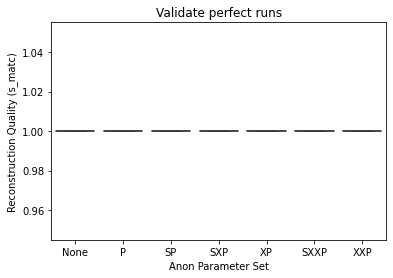

In [5]:
dfPerfect = dfAll.query('a_lab == "None" or a_pri == "all"')
bp = sns.boxplot(x='a_lab',y='s_matc',data=dfPerfect)
bp.set(xlabel = 'Anon Parameter Set', ylabel='Reconstruction Quality (s_matc)',title='Validate perfect runs')

The above shows perfect reconstruction. So after this I'm going to ignore that data. Also let's make three data sets, one each for the three prior knowledge settings ('none' for no prior knowledge, 'half' for knowing half of the rows, 'all-but-one' for knowing every row except one).

In [6]:
dfTemp = dfAll.query("a_lab != 'None'")
dfTemp = dfTemp.query("a_pri != 'all'")
dfNone = dfTemp.query("a_pri == 'none'")
dfHalf = dfTemp.query("a_pri == 'half'")
dfNear = dfTemp.query("a_pri == 'all-but-one'")

## Effect of random seed

The following graphs explore the variation in individual solution runs. The data is for the same size of graph (three columns with three values each), but for 25 separate runs each with a different random seed.

[Text(0.5, 0, 'Anon Parameter Set'),
 Text(0, 0.5, 'Reconstruction Quality (s_matc)'),
 Text(0.5, 1.0, 'Effect of random seed')]

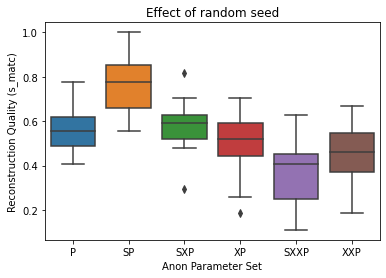

In [7]:
dfRanNone = dfNone.query('t_shape == "[3,3,3]"')
bp = sns.boxplot(x='a_lab',y='s_matc',data=dfRanNone)
bp.set(xlabel = 'Anon Parameter Set', ylabel='Reconstruction Quality (s_matc)',title='Effect of random seed')

These Y axis on these box plots shows the quality of table reconstruction. This is a measure of the fraction of rows in the reconstructed table that have a matching row in the original table. 1.0 is perfect reconstruction. The main takeaway from these graphs is that different random seeds can generate very different reconstruction quality. (The above box plots are derived from 20 seeds.)

The X-axis is the label for the anonymization parameter set. (See below for values.)

The seed has a marked effect on reconstruction quality. This is primarily because many of the tables are quite small, and only a few correctly or incorrectly reconstructed rows can make a big difference in the reconstruction. Indeed by chance some of the reconstructions are perfect (though the attacker has no way of knowing this).

Because of this, we use multiple runs of each attack, with different random seeds, and use the average values in order to get some idea of the effect of different parameters on reconstruction. Towards that end, we generate a dataframe dfAgg which contains summary statistics of the values from different seeds for each of the parameter sets. The summary statistics are avg, min, max, and std-dev. These are denoted by col_av, col_mn, col_mx, and col_sd, for any given column 'col'.

In [8]:
display(dfNone[['a_lab','a_low','a_sds','a_gap','a_sd']].drop_duplicates().sort_values(by=['a_sd']))

,a_lab,a_low,a_sds,a_gap,a_sd
11,SP,2,1.0,2,0.0000
15,SXP,2,1.5,3,0.0000
23,SXXP,2,2.0,4,0.0000
7,P,2,1.0,2,1.0607
19,XP,2,1.5,3,1.5910
27,XXP,2,2.0,4,2.1213


The above shows the parameter settings for the different labels `a_lab`. The leading `S` on the labels indicates that there is no noise, and is used to test cases where some attack averaged out the noise. 'P' means 'private', 'XP' means 'extra private', and 'XXP' means 'extra extra private'. (Showing data for the no noise ('S...') case is in fact probably kind of silly, since in fact there are no attacks that allow for all the noise to be averaged out.)

In [9]:
dfTemp = dfAgg.query("a_lab != 'None'")
dfTemp = dfTemp.query("a_pri != 'all'")
dfAggNone = dfTemp.query("a_pri == 'none'")
dfAggHalf = dfTemp.query("a_pri == 'half'")
dfAggNear = dfTemp.query("a_pri == 'all-but-one'")

display(dfAggNone.head())

,num,t_aids_av,t_aids_mn,t_aids_mx,t_aids_sd,s_err_av,s_err_mn,s_err_mx,s_err_sd,s_errt_av,...,a_sds,a_sd,v_lcf,v_nse,v_nsds_av,v_nsds_mn,v_nsds_mx,v_nsds_sd,t_shape,t_tab
7,30,81.0,81,81,0.0,0.885490,0.705882,1.231373,0.133442,1.551162,...,1.0,1.0607,1.0,1.0,2.200000,2.0,3.0,0.406838,"[3,3,3,3]",random
11,20,81.0,81,81,0.0,0.161961,0.000000,0.313725,0.080801,0.842941,...,1.0,0.0000,1.0,1.0,1.075000,1.0,2.0,0.244680,"[3,3,3,3]",random
15,20,81.0,81,81,0.0,0.546667,0.384314,0.705882,0.092595,1.774142,...,1.5,0.0000,1.0,1.0,1.250000,1.0,3.0,0.500000,"[3,3,3,3]",random
19,30,81.0,81,81,0.0,1.094641,0.862745,1.443137,0.144542,2.439718,...,1.5,1.5910,1.0,1.0,1.833333,1.5,3.0,0.330447,"[3,3,3,3]",random
23,20,81.0,81,81,0.0,0.832549,0.666667,1.192157,0.133304,3.201569,...,2.0,0.0000,1.0,1.0,1.025000,1.0,1.5,0.111803,"[3,3,3,3]",random


In [10]:
print(dfNone[['v_nsds','seed']].groupby(by='v_nsds').count())

        seed
v_nsds      
1.0      596
1.5       81
2.0       65
3.0        8


The above tells us how many of the problems were solved with different values of `v_nsds`. This is the number of standard deviations plus or minus the noisy count within which the solver can assign a count. The smaller the `v_nsds`, the more accurate the solution and so the better the reconstruction.

## Main results

The following plot gives the main result of this attack.

Text(0.5, 0.98, 'Individual Attack Runs (no averaging)')

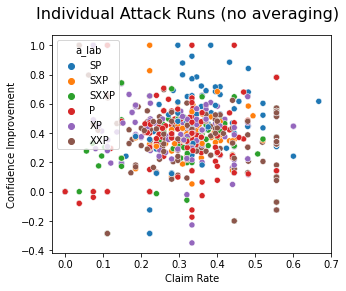

In [11]:
fig, axes = plt.subplots(1,1,figsize=(5,4))
labOrder = ["SP","SXP","SXXP","P","XP","XXP"]
ax = sns.scatterplot(data=dfNone, x="s_cr", y="s_ci",hue='a_lab',hue_order=labOrder)
ax.set(ylabel = 'Confidence Improvement', xlabel='Claim Rate')
fig.suptitle('Individual Attack Runs (no averaging)', fontsize = 16)


The above plot shows Confidence Improvement (CI) and Claim Rate (CR) for every individual attack run (not an average over the 20 seeds per parameter setting). Again it shows substantial variation between runs, with for instance the 'P' setting showing CI ranging from 1.0 (perfect) to -0.4 (far worse than statistical guess). The reason for this difference primarily is that in many cases we are dealing with very small tables and so very few attack attempts and claims. Note that we are not aware of any way that the attacker can determine what the CI for any given attack might be. Therefore, the expected success of the attacker is an average of these values (per anonymization setting).

Text(0.5, 0.98, 'Average per attack set')

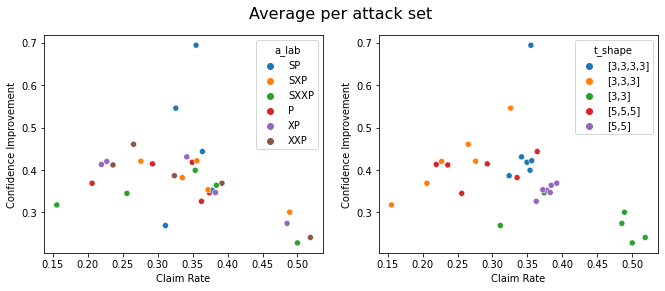

In [12]:
fig, axes = plt.subplots(1,2,figsize=(11,4))
labOrder = ["SP","SXP","SXXP","P","XP","XXP"]
ax1 = sns.scatterplot(data=dfAggNone, x="s_cr_av", y="s_ci_av",hue='a_lab',ax=axes[0],hue_order=labOrder)
ax2 = sns.scatterplot(data=dfAggNone, x="s_cr_av", y="s_ci_av",hue='t_shape',ax=axes[1])
ax1.set(ylabel = 'Confidence Improvement', xlabel='Claim Rate')
ax2.set(ylabel = 'Confidence Improvement', xlabel='Claim Rate')
fig.suptitle('Average per attack set', fontsize = 16)

The above plots show the same data, but averaged over the 20 seeds per anonymization parameters setting. Except for one of the SP (no noise) attacks (three column table with three variables per column '[3,3,3,3]'), no attack has a higher confidence than roughly 0.5. The graph on the right suggests that the shape of the table does have an effect, so this is something we may wish to explore further.

## Effect of prior knowledge

Now let's look at the data regarding prior knowledge.

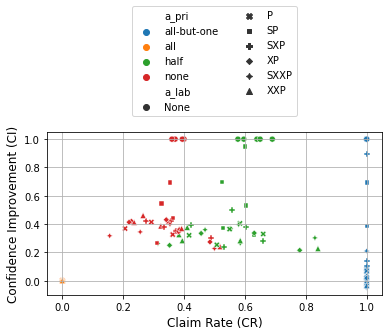

In [13]:
plt.figure(figsize=(6, 3))
ax = sns.scatterplot(data=dfAgg, x="s_cr_av", y="s_ci_av",hue='a_pri',style='a_lab')
plt.xlabel('Claim Rate (CR)',fontsize=12)
plt.ylabel('Confidence Improvement (CI)',fontsize=12)
plt.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=2)

Here we see that increasing prior knowledge does not improve CI. The fact that CR goes up is just an artifact of the measure: we ignore the known rows, leading to a smaller set of rows to make claims from, which in turn means that it is more likely that a given row will have a distinct set of values and therefore a claim. In fact we see for the case where there is only one unknown value (all-but-one), a claim is always made because the one unknown individual is always unique.

Note also that the CI for zzzz

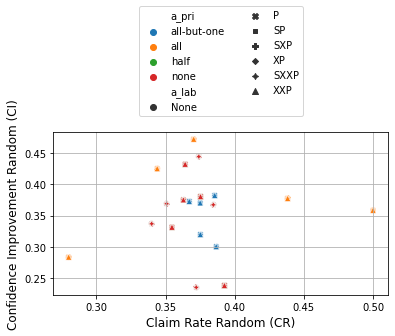

In [14]:
plt.figure(figsize=(6, 3))
ax = sns.scatterplot(data=dfAgg, x="s_cr_r_av", y="s_ci_r_av",hue='a_pri',style='a_lab')
plt.xlabel('Claim Rate Random (CR)',fontsize=12)
plt.ylabel('Confidence Improvement Random (CI)',fontsize=12)
plt.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=2)

TODO: revisit above plot. It isn't making sense to me.

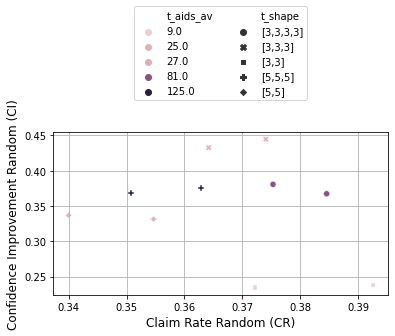

In [15]:
plt.figure(figsize=(6, 3))
ax = sns.scatterplot(data=dfAggNone, x="s_cr_r_av", y="s_ci_r_av",hue='t_aids_av',style='t_shape')
plt.xlabel('Claim Rate Random (CR)',fontsize=12)
plt.ylabel('Confidence Improvement Random (CI)',fontsize=12)
plt.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=2)

From the above graph, I'm trying to figure out why CR's vary. My hypothesis is that CR is entirely driven by how many uniques are in the table. More uniques leads to higher CR. The above doesn't really show us that, because it is just showing number of AIDs (individuals in the table), and not number of uniques. There is a relationship, but it is perfect. TODO.

Text(0.5, 0.98, 'Anonymization quality, all network shapes')

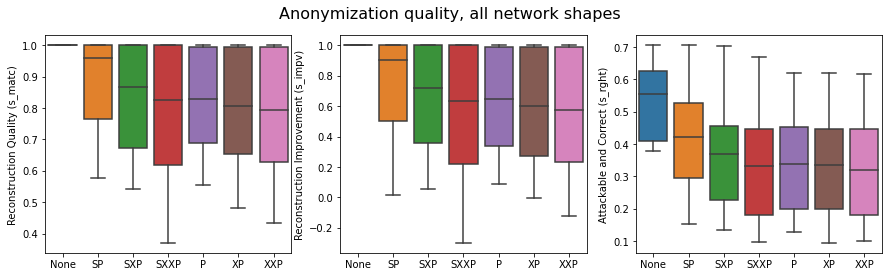

In [16]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
labOrder = ["None", "SP","SXP","SXXP","P","XP","XXP"]
ax1 = sns.boxplot(x='a_lab',y='s_matc_av',order=labOrder,data=dfAgg,ax=axes[0])
ax2 = sns.boxplot(x='a_lab',y='s_impv_av',order=labOrder,data=dfAgg,ax=axes[1])
ax3 = sns.boxplot(x='a_lab',y='s_rght_av',order=labOrder,data=dfAgg,ax=axes[2])
ax1.set(xlabel = '', ylabel='Reconstruction Quality (s_matc)')
ax2.set(xlabel = '', ylabel='Reconstruction Improvement (s_impv)')
ax3.set(xlabel = '', ylabel='Attackable and Correct (s_rght)')
fig.suptitle('Anonymization quality, all network shapes', fontsize = 16)

The graph above compares the different anonymization levels (including those with no noise 'S...'). The box plot shows the results for different table shapes (number of columns and number of distinct values per column) using the average from 10 runs.

The graph on the left displays reconstruction quality (s_matc, already described). The graph in the middle displays the improvement in reconstruction quality over a randomly generated graph with the same shape. In other words, a randomly generated graph with the same shape will naturally have some rows that match the original graph. The middle graph shows how much better the linear reconstruction performs over such a random graph. Values above the zero point on the Y axis are better than random, and below the zero point are worse than random. Except for the SP setting (very little suppression and no noise), reconstruction does only slightly better than random.

An important point to note is that reconstruction does not necessarily imply privacy violation. For instance, consider reconstruction on a L-diversified dataset. The dataset may be reconstructed perfectly, but it is still L-diversified and therefore anonymous. For our tables, there are cases where multiple users have the same value, bestowing a kind of K-anonymity protection on the users. Even if the data for those users is reconstructed correctly, they still are not singled out.

The graph on the right explores this. It assumes that a user is "attackable" if either it can be singled-out or a column value can be inferred with 100% confidence. If two or more users in the original table have the same values across all columns, then those users cannot be singled out and are protected in a K-anonymity sense. Likewise if multiple users have identical values for N-1 columns, but the Nth column has multiple values among those users, then the Nth column cannot be inferred with 100% condidence. These users' privacy is preserved in a L-diversity sense. In both cases, we regard the user as not attackable.

The right side of the above graph shows the fraction of users that are attackable in the above sense, and where reconstruction led to a correct guess as to the user's column values. For the anonymization setting with both noise and suppression, the fraction of rows that are both attackable and correct is less than 20%. zzzz

What we see here is that, although reconstruction quality is generally better for random tables, the actual privacy loss is far less. The fraction of attackable users can be seen in the box for 'None', where reconstruction is perfect. Here we see that the median fraction of users that are attackable is just over 60%.

For all of the suppression parameter settings, less than one-third of the users are attackable and have been correctly guessed. What this means in practice is that users in this table have better than 66% deniability against a reconstruction attack. This is not bad.

There are several take-aways here.

First, a graph with no suppression and no noise ('None') can be reconstructed perfectly. Not a surprise, and serves as partial validation that our reconstruction method works correctly.

Second, an increase in the suppression parameters correlates with poorer reconstruction. Also not a surprise.

NameError: name 'dfNoNoise' is not defined

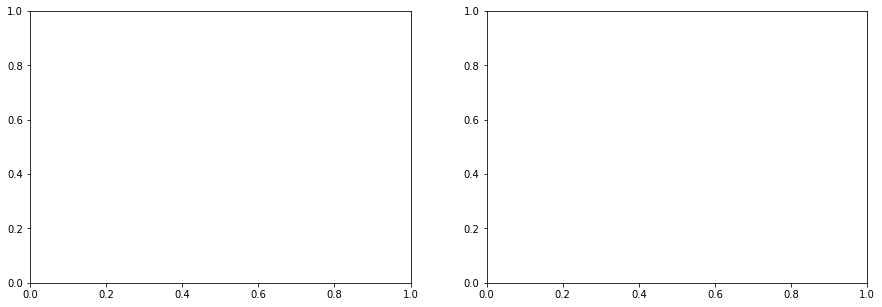

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax1 = sns.boxplot(x='a_lab',y='s_matc_av',data=dfNoNoise,order=labOrder,ax=axes[0])
ax2 = sns.boxplot(x='a_lab',y='s_rght_av',data=dfNoNoise,order=labOrder,ax=axes[1])
ax1.set(xlabel = 'Anonymization parameters', ylabel='Reconstruction Quality (s_matc)')
ax2.set(xlabel = 'Anonymization parameters', ylabel='Attackable and Correct (s_rght)')
fig.suptitle('Effect of LCF parameters (no noise)', fontsize = 16)

An important point to note is that reconstruction does not necessarily imply privacy violation. For instance, consider reconstruction on a L-diversified dataset. The dataset may be reconstructed perfectly, but it is still L-diversified and therefore anonymous. For our tables, there are cases where multiple users have the same value, bestowing a kind of K-anonymity protection on the users. Even if the data for those users is reconstructed correctly, they still are not singled out.

The above graph explores this. It assumes that a user is "attackable" if either it can be singled-out or a column value can be inferred with 100% confidence. If two or more users in the original table have the same values across all columns, then those users cannot be singled out and are protected in a K-anonymity sense. Likewise if multiple users have identical values for N-1 columns, but the Nth column has multiple values among those users, then the Nth column cannot be inferred with 100% condidence. These users' privacy is preserved in a L-diversity sense. In both cases, we regard the user as not attackable.

The right side of the above graph shows the fraction of users that are attackable in the above sense, and where reconstruction led to a correct guess as to the user's column values. (The left graph is reconstruction quality, same as before.)

What we see here is that, although reconstruction quality is generally better for random tables, the actual privacy loss is far less. The fraction of attackable users can be seen in the box for 'None', where reconstruction is perfect. Here we see that the median fraction of users that are attackable is just over 60%.

For all of the suppression parameter settings, less than one-third of the users are attackable and have been correctly guessed. What this means in practice is that users in this table have better than 66% deniability against a reconstruction attack. This is not bad.



## Effect of table size on solution time

We have been working with very small tables (100s to a few thousand users). The reason for this is that the time it takes for the solver to execute grows rapidly with table size. The following scatter plot shows solve time against the number of users in the table as well as table shape.

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(16,4))
ax1 = sns.scatterplot(data=dfAll, x='s_cons', y='s_tim', hue='t_shape',ax=axes[0])
ax2 = sns.scatterplot(data=dfAll, x='s_cons', y='s_tim', hue='a_lab',ax=axes[1])
ax3 = sns.scatterplot(data=dfAll, x='s_cons', y='s_tim', hue='t_aids',ax=axes[2])
ax1.set(yscale="log",xscale="log")
ax2.set(yscale="log",xscale="log")
ax3.set(yscale="log",xscale="log")

By the way, here we can see that as the size of the table grows (more columns, more values per column), the length of time to generate a solution grows dramatically. The three graphs here are a (failed) attempt to understand why some experiments take longer than others. Of course, from the left graph we see that bigger tables (more values or more columns) take longer, but there is a substantial difference in run times for the same table which we don't understand.


## Suppression and Noise

In [ ]:
dfBoth = dfAggCore.query("a_sd == 2 and a_lcfL == 2 and a_lcfH == 6 and t_shape in ['2,2,2,2]','[3,3,3]','[6,6,6]','[3,3,3,3]','[5,5,5,5]','[10,10,10]']")
fig, axes = plt.subplots(1,3,figsize=(15,5))
ax1 = sns.boxplot(x='t_tab',y='s_matc_av',data=dfBoth,order=["complete", "random"],ax=axes[0])
ax2 = sns.boxplot(x='t_tab',y='s_impv_av',data=dfBoth,order=["complete", "random"],ax=axes[1])
ax3 = sns.boxplot(x='t_tab',y='s_rght_av',data=dfBoth,order=["complete", "random"],ax=axes[2])
ax1.set(xlabel = 'Table Type (t_tab)', ylabel='Reconstruction Quality (s_matc)')
ax2.set(xlabel = 'Table Type (t_tab)', ylabel='Reconstruction Improvement over Random (s_impv)')
ax3.set(xlabel = 'Table Type (t_tab)', ylabel='Attackable and Correct (s_rght)')
fig.suptitle('Effect of noise and LCF (constraint width = 2, SD=2, LCF(2,6))', fontsize = 16)

The above graph may be regarded as the main result of this study. Here we show the absolute reconstruction quality (left), the improvement in reconstruction quality over random guessing (middle), and deniability: the fraction of users that are attackable with a correct guess (right). For these reconstruction attacks, we have noise SD=2 and LCF(2,6), which are roughly the amounts used in the Aircloak system used to defend against a wide variety of other attacks.

The takeaway here is that these levels of protection are effective against the reconstruction attack we used. The median reconstruction quality is for all practical purposes no better than random guessing. For random tables, median deniability is roughly 90%.

## Appendix A: Operation of Basic Linear Reconstruction Attack

The basic LR attack builds a set of constraints based on the results of queries made to the anonymized database. We assume that the LR attacker knows all column values, and therefore makes queries specifically for all possible column value combinations.

The basic LR attack builds a set of constraints based on the results of queries made to the anonymized database. We assume that the LR attacker knows all column values, and therefore makes queries specifically for all possible column value combinations. This is a reasonable assumption because in any event the attacker can learn the values by querying each individual column for ranges of values that are large enough that answers won't be suppressed.

We also assume that the LR attacker knows the anonymizer parameters (LCF bounds and noise SD). Finally, as a programming convenience we assume that the LR attacker knows the number of rows in the table. In practice the attacker could make a good guess with only slightly degraded reconstruction quality.

Each query requests the count of distinct AIDs, and returns either a noisy count or a suppression indication. Constraints are generated from these answers.

A typical query (here for two column dimensions) is:

```
SELECT count(DISTINCT aid)
FROM table
WHERE c1 = 1 and c2 = 2
```

In our code, we used the python PuLP linear program optimizer library (https://coin-or.github.io/pulp/index.html). Our attack is similar in construction to the Sudoku solver example provided by PuLP (https://coin-or.github.io/pulp/CaseStudies/a_sudoku_problem.html).

We describe the approach by example. This specific example has two columns and two column values per column. The column names are i1 and i2. The column values are integers.  The table has only four AIDs, a0 through a3. Every column/value combination and associated count is referred to as a bucket. Ci0V0 denotes the one-dimensional bucket with column i0 and value 0. Ci0V1.Ci1V10 denotes the two-dimensional bucket with value 1 in column i0, and value 10 in column i1.

The LP problem definition starts with a set of binary integer variables (possible values 0 or 1). There is one variable for every possible assignment of every AID to every bucket. Examples are:

```
Choice_a0_Ci1V11
Choice_a1_Ci0V0
Choice_a1_Ci0V0.Ci1V10
```

The first variable represents AID a0 in bucket Ci1V11. Its value is 1 if the AID is in the bucket, and 0 if not.

There are three kinds of constraints:

1. Constraints that ensure that any given AID is in only one bucket for each possible column combination.
2. Constraints that ensure that any given bucket has the number of AIDs determined by the bucket count.
3. Constraints that ensure that if an AID is in a given bucket with dimension N, then it is also in the dimension N+1 buckets that are sub-buckets of the bucket.

An example of the first kind is:

```
Choice_a0_Ci0V0 + Choice_a0_Ci0V1 = 1
```

This ensures that AID a0 is in only one of the buckets among all of the column i0 buckets (one dimension). A similar constraint would exist for every user and every combination of buckets.

An example of the second kind is:

```
Choice_a0_Ci0V0.Ci1V11 + Choice_a1_Ci0V0.Ci1V11 + Choice_a2_Ci0V0.Ci1V11 + Choice_a3_Ci0V0.Ci1V11 >= 2
Choice_a0_Ci0V0.Ci1V11 + Choice_a1_Ci0V0.Ci1V11 + Choice_a2_Ci0V0.Ci1V11 + Choice_a3_Ci0V0.Ci1V11 <= 6
```

This pair of constraints ensures that the two-dimensional bucket Ci0V0.Ci1V11 has between 2 and 6 AIDs. This range is determined by bounds on the noise above and below the reported noisy count. In this case, the noise SD=1 and the attacker places a bound of plus or minus 2 SDs. The noisy count is 4, so the range of values is 2 to 6.

Similarly, if a bucket is suppressed, then a pair of constraints is composed to encompass the range of possible suppressable counts. So if the LCF threshold is a noisy value between 2 and 4, then the possible counts of a suppressed bucket is 0 to 3.

An example of the third kind is:

```
Choice_a0_Ci0V0.Ci1V10 + Choice_a0_Ci0V1.Ci1V10 - Choice_a0_Ci1V10 = 0
```

This constraint says that if AID a0 is in one-dimensional bucket Ci1V10, then it must be in one and only one of the two-dimensional buckets that include Ci1V0 (in this case Ci0V0.Ci1V10 and Ci0V1.Ci1V10).


## Appendix B: Column Definitions

In [ ]:
display(dfAll.columns)

The following definitions are for the raw results (from `dfAll`, one row per reconstruction)

### Table Parameters
* *t_aids*: The number of AIDs (distinct users) in the table (also number of rows: each row is assumed to be one AID)
* *t_shape*: The number of columns and distinct values per column (`[5,5,5]` for instance has three columns with 5 distinct values each)
* *t_tab*: The type of table. 'complete' means that every possible combination of values has one row. 'random' means that each value is randomly assigned uniformly (no correlation between columns)

### Anonymization Parameters
* *a_lcfL, a_lcfH*: The lower and upper bounds on the LCF threshold (uniformly randomly selected). `[0,0]` means no LCF.
* *a_sd*: The standard deviation of added noise. 0 means no noise.

### Solution parameters
* *v_lcf*: The fraction of the LCF threshold range that is penalty-free if elastic constraints used.
* *v_nse*: The fraction of the noise constraints range that is penalty-free if elastic constraints used.
* *v_nsds*: The number of standard deviations to use as the constraints range for noise (the constraints range is `v_nsds * a_sd`)

### Solution results
#### Solution quality measures
* *s_rght*: Fraction of attackable rows where the attack is correct (a singling-out or inferrence guess was correct)
* *s_wrng*: Fraction of attackable rows where the attack is not correct
* *s_matc*: Fraction of correctly reconstructed rows (reconstruction quality)
* *s_impv*: Improvement of reconstruction quality over a randomly constructed table
* *s_nona*: Fraction of rows that are not attackable, according to the reconstructed table (could not be singled-out or inferred)
* *s_err*: Average of absolute errors in bucket counts between the original table and the reconstructed table
* *s_errt*: Average of absolute errors in elastic target, original versus reconstructed

#### Solver operational measures
* *s_tim*: Length of solver time (seconds)
* *s_bkts*: Total number of buckets (all dimensions)
* *s_choi*: Total number of possible AID to value assignments
* *s_cons*: Total number of solver constraints
* *s_ign*: Total number of buckets ignored when making constraints
* *s_str*: Total number of rows stripped away because all rows for a dimension were suppressed
* *s_sup*: Total number of buckets suppressed by LCF
* *s_sol*: Boolean indicating whether solver found a solution or not (1 = solution found, 0 = no solution found)

All of the numeric parameters from the above are summarized in groups with the same experimental parameters but different seeds. Each parameter is summarized with average, min, max, and standard deviation (i.e. s_wrng has s_wrng_av, s_wrng_mn, s_wrng_mx, and s_wrng_sd).


In [ ]:
print(dfAgg.columns)

## Appendix C: Other measures

### Large noise constraint width

For larger problems (more columns and more values), the solver takes a very long time to solve. One way to get the solver to solve faster is to increase the constraint width for noise (v_nsds). This allows for more solutions at the cost of reconstruction accuracy, but at least let's the solver more easily and quickly find a valid solution.

In [ ]:
dfBigWindow = dfAll.query('v_nsds > 4')
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax1 = sns.barplot(x='v_nsds',y='s_tim',data=dfBigWindow,ax=axes[0])
ax2 = sns.barplot(x='v_nsds',y='s_matc',data=dfBigWindow,ax=axes[1])
ax1.set(xlabel = 'Noise Constraint Width', ylabel='Solution Time (s_tim)\nLog scale',yscale='log')
ax2.set(xlabel = 'Noise Constraint Width', ylabel='Reconstruction Quality (s_matc)')
fig.suptitle('Effect of large noise constraint width (t_tab = [10,10,10,10])', fontsize = 16)

Note that the above are for single data points. From the solver time (left graph), we see that constraint widths of 128 and 256 solve quickly (less than a minute), but with width 64 it takes over 50K seconds (14 hours). The reconstruction quality is poor in all cases.

### Increasing number of values per column

Here we explore the effect of only increasing the number of values per column, while keeping the number of columns constant.

In [ ]:
dfValsPerCol = dfAggCore.query('a_sd == 2 and t_shape in ("[2,2,2]","[3,3,3]","[4,4,4]","[5,5,5]","[6,6,6]","[7,7,7]") and l_lcf == "LCF(2,6)" and v_nsds == 2 and t_tab == "random"')
fig, axes = plt.subplots(1,3,figsize=(18,4))
ax1 = sns.barplot(x='t_shape',y='s_tim_av',data=dfValsPerCol,ax=axes[0])
ax2 = sns.barplot(x='t_shape',y='s_impv_av',data=dfValsPerCol,ax=axes[1])
ax3 = sns.barplot(x='t_shape',y='s_rght_av',data=dfValsPerCol,ax=axes[2])
ax1.set(xlabel = 'Table Shape', ylabel='Solution Time (s_tim_av)\nLog scale',yscale='log')
ax2.set(xlabel = 'Table Shape', ylabel='Improvement over Random (s_impv)')
ax3.set(xlabel = 'Table Shape', ylabel='Attackable and Correct (s_rght)')
fig.suptitle('Effect of number of columns', fontsize = 16)

The reconstruction quality doesn't change significantly with a change in the number of columns. This gives us some preliminary confidence that attacks with more values, should someone figure out how to make them scale better, won't lead to substantially better reconstruction.

In [ ]:
dfCols = dfAggCore.query('a_sd == 2 and t_shape in ("[2,2]","[2,2,2]","[2,2,2,2]","[2,2,2,2,2]","[2,2,2,2,2,2]") and l_lcf == "LCF(2,6)" and v_nsds == 2 and t_tab == "random"')
fig, axes = plt.subplots(1,3,figsize=(18,4))
ax1 = sns.barplot(x='t_shape',y='s_tim_av',data=dfCols,ax=axes[0])
ax2 = sns.barplot(x='t_shape',y='s_impv_av',data=dfCols,ax=axes[1])
ax3 = sns.barplot(x='t_shape',y='s_rght_av',data=dfCols,ax=axes[2])
ax1.set(xlabel = 'Table Shape', ylabel='Solution Time (s_tim_av)\nLog scale',yscale='log')
ax2.set(xlabel = 'Table Shape', ylabel='Improvement over Random (s_impv)')
ax3.set(xlabel = 'Table Shape', ylabel='Attackable and Correct (s_rght)')
fig.suptitle('Effect of number of columns', fontsize = 16)

Here we are seeing some trend towards better reconstruction with more columns. More interesting, however is that we see much better reconstruction when there are two values versus three values.